In [1]:
import math
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None

# pip install tensorflow

# Modelo de deep learning baseado no histórico recente (LSTM)

In [2]:
acao = "MGLU3.SA"

inicio = "2014-12-31"
final = "2022-09-15"

dados_acao = pdr.get_data_yahoo(acao, inicio, final)
dados_acao

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,0.243750,0.243750,0.231562,0.232812,0.215259,6323200
2015-01-05,0.235625,0.240625,0.229687,0.237187,0.219304,10326400
2015-01-06,0.238437,0.238437,0.233125,0.234062,0.216414,12572800
2015-01-07,0.237500,0.242187,0.234687,0.241875,0.223638,6454400
2015-01-08,0.239375,0.242187,0.237500,0.240000,0.221905,8393600
...,...,...,...,...,...,...
2022-09-08,4.060000,4.360000,4.040000,4.290000,4.290000,179911400
2022-09-09,4.420000,4.430000,4.300000,4.380000,4.380000,134934100
2022-09-12,4.440000,4.820000,4.430000,4.790000,4.790000,202900500


In [3]:
# não pode ser ajustados

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[0.232812  ],
       [0.237187  ],
       [0.234062  ],
       ...,
       [4.78999996],
       [4.69999981],
       [4.46999979]])

In [4]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)
tamanho_dados_treinamento

1532

In [5]:
# escalar os dados entre 0 e 1, para deixar mais fácil o processamento
# dados em escala pré definidas são mais fáceis de lidar

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento)
)) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

In [8]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]
i = 60
dados_para_treinamento[i - 60: i, 0]
dados_para_treinamento[i, 0]
len(dados_para_treinamento)

1532

In [9]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

# dados que serão usados para gerar o resultado
treinamento_x = []
# cotacação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):
    
    # 60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])
    
    if i <= 61:
        print(treinamento_x)
        print(treinamento_y)

[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00686247, 0.00691944, 0.00688527,
       0.00691944, 0.00686247, 0.00663453, 0.00641797, 0.0066915 ,
       0.00663453, 0.00668012, 0.006361  , 0.00628121, 0.00617865,
       0.00582532, 0.00575694, 0.00588233, 0.00549483, 0.0056088 ,
       0.00582532, 0.00585953, 0.00613306, 0.00612165, 0.00620145,
       0.00640659, 0.00622424, 0.0063838 , 0.00577974, 0.00581395,
       0.00558601, 0.00520988, 0.0051415 , 0.00495915, 0.00466283,
       0.00491356, 0.00486797, 0.00515292, 0.00487939, 0.00469704,
       0.00462865, 0.00457165, 0.00468562, 0.00470842, 0.00470842,
       0.00466283, 0.00458307, 0.00456027, 0.00452606, 0.00462865])]
[0.004685621274704243]
[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00

In [10]:
# transformando as listas em arrays e dando reshape 3d

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

treinamento_x

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

treinamento_x

array([[[0.00737532],
        [0.00753488],
        [0.00742091],
        ...,
        [0.00456027],
        [0.00452606],
        [0.00462865]],

       [[0.00753488],
        [0.00742091],
        [0.00770585],
        ...,
        [0.00452606],
        [0.00462865],
        [0.00468562]],

       [[0.00742091],
        [0.00770585],
        [0.00763747],
        ...,
        [0.00462865],
        [0.00468562],
        [0.00485659]],

       ...,

       [[0.88110614],
        [0.85156498],
        [0.83332972],
        ...,
        [0.87600022],
        [0.88074142],
        [0.89423547]],

       [[0.85156498],
        [0.83332972],
        [0.83952971],
        ...,
        [0.88074142],
        [0.89423547],
        [0.88402378]],

       [[0.83332972],
        [0.83952971],
        [0.84864734],
        ...,
        [0.89423547],
        [0.88402378],
        [0.91502372]]])

In [11]:
# construindo o modelo

modelo = Sequential()

# vamos criar um modelo com 50 neurônios
# return sequences = True pois vamos usar outro LSTM depois
# definir o shape, que no caso são 60 informações para gerar uma.
# Adicionar mais neurônios com o dense, 25 e 1
# Não se apegue a isso agora, é apenas uma arquitetura de deep learning

modelo.add(LSTM(50, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))


In [12]:
# compilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
# é o clássico erro médio quadrático da que é usado em regressão linear
# otimizador e medida de erro

modelo.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# agora com o modelo compilado e os dados, podemos treinar o modelo
modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1472/1472 [==============================] - 48s 30ms/step - loss: 0.0019


In [14]:
# cruar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]
teste_x = []
teste_y = cotacao[tamanho_dados_treinamento:, :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i-60: i, 0])

In [15]:
# reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [16]:
# pegando predições do modelo
predicoes = modelo.predict(teste_x)

# tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

array([[25.379389 ],
       [25.414995 ],
       [25.343035 ],
       [25.231003 ],
       [25.183453 ],
       [25.167896 ],
       [25.162928 ],
       [25.116999 ],
       [25.075686 ],
       [25.024563 ],
       [24.874537 ],
       [24.67675  ],
       [24.435457 ],
       [24.158073 ],
       [23.808146 ],
       [23.43149  ],
       [23.039675 ],
       [22.64246  ],
       [22.289862 ],
       [21.9959   ],
       [21.76906  ],
       [21.597746 ],
       [21.483274 ],
       [21.386894 ],
       [21.406643 ],
       [21.48448  ],
       [21.595987 ],
       [21.754475 ],
       [21.92694  ],
       [22.102995 ],
       [22.253647 ],
       [22.36353  ],
       [22.437769 ],
       [22.457815 ],
       [22.476961 ],
       [22.49111  ],
       [22.457664 ],
       [22.380598 ],
       [22.25721  ],
       [22.09839  ],
       [21.935099 ],
       [21.752754 ],
       [21.57925  ],
       [21.395206 ],
       [21.241848 ],
       [21.075348 ],
       [20.919369 ],
       [20.73

In [17]:
# pegando o erro médio quadrático (RMSE)
rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.9666539271880068

In [18]:
# criando o gráfico do modelo

treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({'Close': dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                         'predicoes': predicoes.reshape(len(predicoes))})

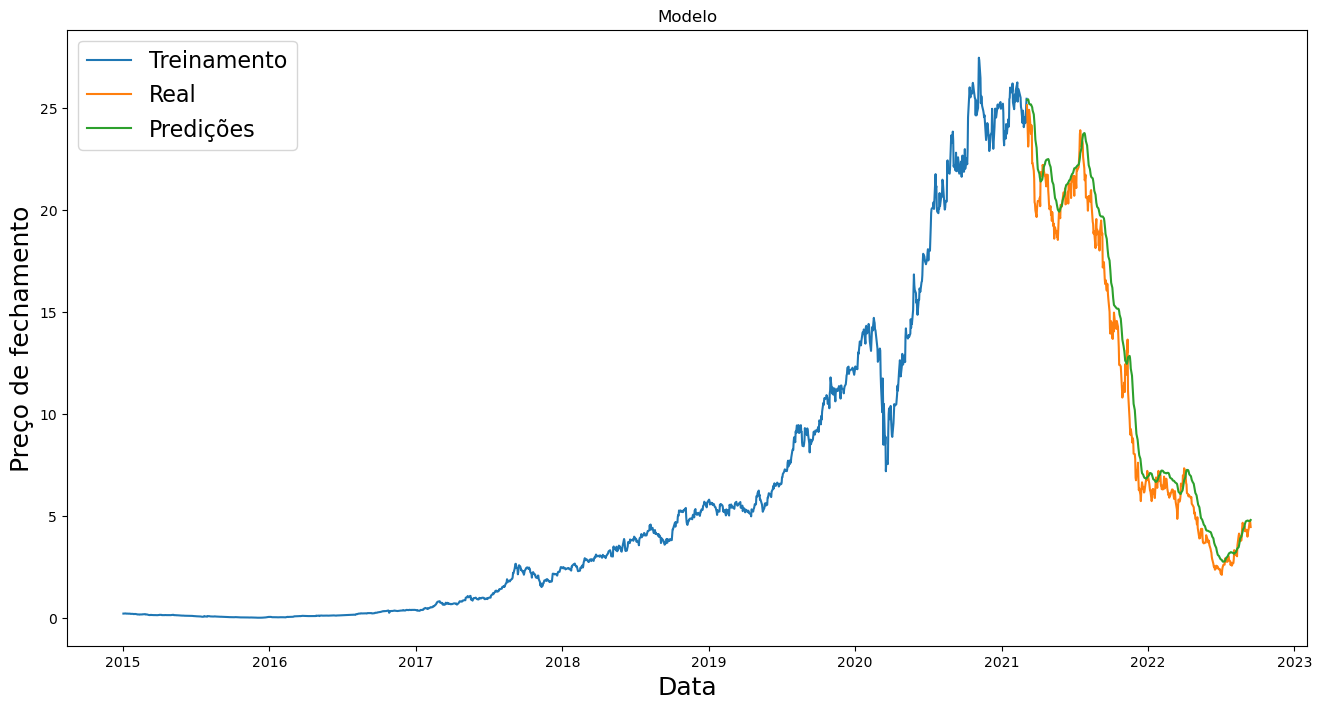

In [19]:
plt.figure(figsize = (16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de fechamento', fontsize=18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [20]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2021-03-05,25.129999,25.379389
2021-03-08,23.100000,25.414995
2021-03-09,23.389999,25.343035
2021-03-10,24.900000,25.231003
2021-03-11,24.799999,25.183453
...,...,...
2022-09-08,4.290000,4.778659
2022-09-09,4.380000,4.766988
2022-09-12,4.790000,4.760753


In [21]:
# o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Será que isso foi feito?
# calcular média de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0,
                                                            True, False)

df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0,
                                                            True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero'],
                                                                                                    True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-03-08,23.100000,25.414995,-0.080780,0.001403,False,True,False,0.080780
2021-03-09,23.389999,25.343035,0.012554,-0.002831,True,False,False,0.012554
2021-03-10,24.900000,25.231003,0.064558,-0.004421,True,False,False,0.064558
2021-03-11,24.799999,25.183453,-0.004016,-0.001885,False,False,True,0.004016
2021-03-12,24.570000,25.167896,-0.009274,-0.000618,False,False,True,0.009274
...,...,...,...,...,...,...,...,...
2022-09-08,4.290000,4.778659,0.072500,-0.002210,True,False,False,0.072500
2022-09-09,4.380000,4.766988,0.020979,-0.002442,True,False,False,0.020979
2022-09-12,4.790000,4.760753,0.093607,-0.001308,True,False,False,0.093607


In [22]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado
media_lucro=df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()
exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado
ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.033397
True     0.033881
Name: variacao_percentual_acao_abs, dtype: float64
1.014506519344567
0.5261780104712042
0.20034321466966715


In [23]:
# criando um código que você passa 60 dias e ele devolve a cotação
# resumindo: vamos descobrir o preço da petrobras de hoje/amanhã com esse modelo

data_hoje = datetime.now()

# se quiser escolher um dia, basta fazer assim

data_hote = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    final = data_hoje
    inicial = datetime.now() - timedelta(days=252)
else:
    final = data_hoje - timedelta(days=1)
    inicial = datetime.now() - timedelta(days=252)

# não vai botar outra ação aqui hein kkkkk
cotacoes = pdr.get_data_yahoo(acao, inicial, final)
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x - teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

[*********************100%***********************]  1 of 1 completed
[[3.7704685]]


# Sugestões:

- Melhorar as estatísticas de avaliação (dias seguidos ganhando, max DD etc)
- Rodar pra todas as ações do ibovespa e criar uma expectativa matemática da expectativa matemática. Isso vai deixar o resultado final ainda mais robusto, definindo a alocação do $ baseado na liquidez

In [24]:
dados_acao

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,0.243750,0.243750,0.231562,0.232812,0.215259,6323200
2015-01-05,0.235625,0.240625,0.229687,0.237187,0.219304,10326400
2015-01-06,0.238437,0.238437,0.233125,0.234062,0.216414,12572800
2015-01-07,0.237500,0.242187,0.234687,0.241875,0.223638,6454400
2015-01-08,0.239375,0.242187,0.237500,0.240000,0.221905,8393600
...,...,...,...,...,...,...
2022-09-08,4.060000,4.360000,4.040000,4.290000,4.290000,179911400
2022-09-09,4.420000,4.430000,4.300000,4.380000,4.380000,134934100
2022-09-12,4.440000,4.820000,4.430000,4.790000,4.790000,202900500
